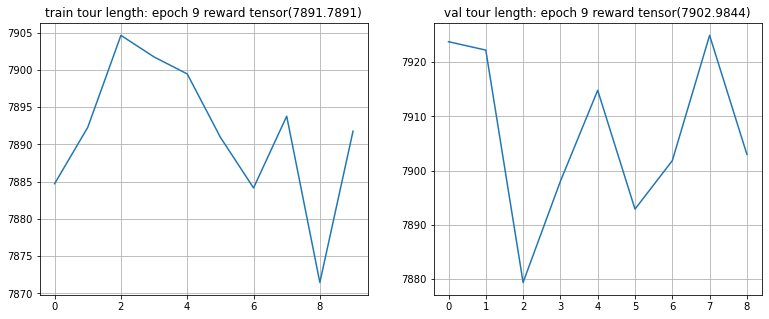

RuntimeError: stack expects each tensor to be equal size, but got [20, 100] at entry 0 and [20, 200] at entry 90

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 24 11:02:46 2018

Source: https://github.com/higgsfield/np-hard-deep-reinforcement-learning/blob/master/Neural%20Combinatorial%20Optimization.ipynb

@author: tliliuw
"""
import os
 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import datetime
import math
import numpy as np
%matplotlib inline 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

USE_CUDA=True

from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
#matplotlib inline

# record starting time
start = datetime.datetime.now()

class PFSPDataset(Dataset):
    def __init__(self,num_machines,num_jobs,num_samples,random_seed=111):
        super(PFSPDataset,self).__init__()
        torch.manual_seed(random_seed)
        self.data_set=[]
        for l in tqdm(range(num_samples)):
            x=np.random.randint(1,100,size=(num_machines,num_jobs))
            x=torch.Tensor(x)
            self.data_set.append(x)
        self.size=len(self.data_set)
    
    def __len__(self):
        return self.size
        
    def __getitem__(self,idx):
        return self.data_set[idx]

def read_from_file(filename):
    with open(filename, "r") as fic:
        num_jobs = int(fic.readline())
        num_machines = int(fic.readline())
        matrix_p = np.zeros([num_jobs, num_machines])
        for i in range(num_jobs):
            p_i = fic.readline().split()
            for j in range(num_machines):
                matrix_p[i][j] = int(p_i[j])
    fic.close()
    return num_machines, num_jobs, matrix_p

def data_masks(all_usr_pois, item_tail, num_machines):

	# 统计子列表中最长长度
    us_lens = [len(upois) for upois in all_usr_pois]
    len_max = max(us_lens)
    
    # zip()为了让两个列表一一对应，并减少内存使用
    # 填充0
    us_pois = [upois + item_tail * (num_machines - len_max) for upois in all_usr_pois]

    return us_pois


class TestDataset_new():
    def __init__(self,num_machines,num_jobs):
        super(TestDataset_new,self).__init__()
        self.data_set=[]
        item_tail=[0]
        for l in tqdm(range(120)):
            maxtrix_p=[]
            filename='C:\\Users\\MSI-PC\\Desktop\\AI Group\\代码例子\\np-hard-deep-reinforcement-learning-master\\Taillard\\'+str(l+1)+'.txt'
            #filename='E:\\02 SDU Research\\04 Deep_Learning\\Taillard\\'+str(l+21)+'.txt'
            n_machine, n_job, matrix_p = read_from_file(filename)
            print('matrix_p',matrix_p)
            print
            matrix_p_new=data_masks(matrix_p.tolist(),item_tail,num_machines)
            job_diff=num_jobs-n_job    #check if the number of jobs of the test instance is less than training size
            if job_diff>0:   # pad zero list to the end
                matrix_p_new.extend([ [0] * (num_machines) for _ in range(job_diff)])
            x=np.transpose(matrix_p_new)
            x=torch.Tensor(x)
            self.data_set.append(x)
        self.size=len(self.data_set)
    
    def __len__(self):
        return self.size
        
    def __getitem__(self,idx):
        return self.data_set[idx]

class TestDataset():
    def __init__(self):
        super(TestDataset,self).__init__()
        self.data_set=[]
        for l in tqdm(range(120)):
            maxtrix_p=[]
            filename='C:\\Users\\MSI-PC\\Desktop\\AI Group\\代码例子\\np-hard-deep-reinforcement-learning-master\\Taillard\\'+str(l+1)+'.txt'
            #filename='E:\\02 SDU Research\\04 Deep_Learning\\Taillard\\'+str(l+21)+'.txt'
            n_machine, n_job, matrix_p = read_from_file(filename)
            x=np.transpose(matrix_p)
            x=torch.Tensor(x)
            self.data_set.append(x)
        self.size=len(self.data_set)
    
    def __len__(self):
        return self.size
        
    def __getitem__(self,idx):
        return self.data_set[idx]
    
def reward(sample_solution,USE_CUDA=False):
    """
    Args:
        sample_solution seq_len of [batch_size]
        sample_solution, a list 
    """

    batch_size=sample_solution[0].size(0)      # size of batch：第零个矩阵的行
    num_machines=sample_solution[0].size(1)    # number of machines：第0个矩阵的列
    num_jobs=len(sample_solution)              # number of jobs：有多少个矩阵

    tour_len=Variable(torch.zeros([batch_size]))   # record the final results
    tour_len_b=Variable(torch.zeros([batch_size,num_machines]),requires_grad = False)    # tour_len backup

    for i in range(num_jobs):     # iteration of number of jobs
        for j in range(num_machines):   # iteration of number of machiens
            x=sample_solution[i] # first jobs in the batch   Variable(sample_solution[i])
            y=torch.zeros([batch_size,2])   
            if j==0:
                tour_len_b[:,j]=torch.add(tour_len_b[:,j],x[:,j].cpu())
                #tour_len_b[:,j]=torch.add(tour_len_b[:,j],x[:,j])
            else:
                y[:,0]=tour_len_b[:,j-1].data
                y[:,1]=tour_len_b[:,j].data
                y1=torch.max(y,1)    # to find the max 
                y2=Variable(y1[0])
                tour_len_b[:,j]=torch.add(y2,x[:,j].cpu())

    tour_len_b1=torch.max(tour_len_b,1) 
    tour_len=tour_len_b1[0]
    return tour_len


# two types of attention mechanisms: Dot and Bahdanau
class Attention(nn.Module):
    def __init__(self,hidden_size,use_tanh=False,C=10,name='Bahdanau',use_cuda=USE_CUDA):
        super(Attention,self).__init__()
        
        self.use_tanh=use_tanh
        self.C=C
        self.name=name
        
        if name=='Bahdanau':
            self.W_query=nn.Linear(hidden_size,hidden_size)
            self.W_ref=nn.Conv1d(hidden_size,hidden_size,1,1)
            
            V=torch.FloatTensor(hidden_size)
            if use_cuda:
                V=V.cuda()
            self.V=nn.Parameter(V)
            self.V.data.uniform_(-(1./math.sqrt(hidden_size)),1./math.sqrt(hidden_size))

    def forward(self,query,ref):
        """
        Args:
            query:[batch_size*hidden_size]
            ref:[batch_size*seq_len*hidden_size]
        """
        
        batch_size=ref.size(0)
        seq_len=ref.size(1)
        
        if self.name=='Bahdanau':
            ref=ref.permute(0,2,1)
            query=self.W_query(query).unsqueeze(2)  # [batch_size*hidden_size*1]
            ref=self.W_ref(ref) #[batch_size*hidden_size*seq_len]
            expanded_query=query.repeat(1,1,seq_len)  #[batch_size*hidden_size*seq_len]
            V=self.V.unsqueeze(0).unsqueeze(0).repeat(batch_size,1,1) #[batch_size*1*hidden_size]
            logits=torch.bmm(V,F.tanh(expanded_query+ref)).squeeze(1)
            
        elif self.name=='Dot':
            query=query.unsqueeze(2)
            logits=torch.bmm(ref,query).squeeze(2)  #[batch_size*seq_len*1]
            ref=ref.permute(0,2,1)
            
        else:
            raise NotImplementedError
            
        if self.use_tanh:
            logits=self.C*F.tanh(logits)
        else:
            logits=logits
        return ref,logits
        
#Node embedding
#This is simple node embedding. For more advanced methods see Graph Embedding Techniques, Applications, and Performance: A Survey

class GraphEmbedding(nn.Module):
    def __init__(self,input_size,embedding_size,use_cuda=USE_CUDA):
        super(GraphEmbedding,self).__init__()
        self.embedding_size=embedding_size
        self.use_cuda=use_cuda
        
        self.embedding=nn.Parameter(torch.FloatTensor(input_size,embedding_size))
        self.embedding.data.uniform_(-(1./math.sqrt(embedding_size)),1./math.sqrt(embedding_size))
        
    def forward(self,inputs):
        if self.use_cuda:
            inputs=inputs.cuda(0)
            
        batch_size=inputs.size(0)
        seq_len=inputs.size(2)
        embedding=self.embedding.repeat(batch_size,1,1)
        if self.use_cuda:
            embedding=embedding.cuda(0)
            
        embedded=[]
        inputs=inputs.unsqueeze(1)
        for i in range(seq_len):
            embedded.append(torch.bmm(inputs[:,:,:,i].float(),embedding))
        embedded=torch.cat(embedded,1)
        return embedded
        
# Pointer Network

class PointerNet(nn.Module):
    def __init__(self,num_machines,embedding_size,hidden_size,seq_len,n_glimpses,tanh_exploration,use_tanh,attention,use_cuda=USE_CUDA):
        super(PointerNet,self).__init__()

        self.embedding_size=embedding_size
        self.hidden_size=hidden_size
        self.n_glimpses=n_glimpses
        self.seq_len=seq_len
        self.use_cuda=use_cuda
        
        self.embedding=GraphEmbedding(num_machines,embedding_size,use_cuda=use_cuda)
        self.encoder=nn.LSTM(embedding_size,hidden_size,batch_first=True)
        self.decoder=nn.LSTM(embedding_size,hidden_size,batch_first=True)
        self.pointer=Attention(hidden_size,use_tanh=use_tanh,C=tanh_exploration,name=attention,use_cuda=use_cuda)
        self.glimpse=Attention(hidden_size,use_tanh=False,name=attention,use_cuda=use_cuda)
        self.decoder_start_input=nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1./math.sqrt(embedding_size)),1./math.sqrt(embedding_size))
        
    def apply_mask_to_logits(self,logits,mask,idxs):
        batch_size=logits.size(0)
        clone_mask=mask.clone()
        
        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data]=1
            logits[clone_mask]=-np.inf
        return logits,clone_mask
        
    def forward(self,inputs):
        """
        Args:
            inputs:[batch_size*1*sourceL]
        """
        if self.use_cuda:
            inputs=inputs.cuda(0)
            self.encoder=self.encoder.cuda()
            self.decoder=self.decoder.cuda()
        
        batch_size=inputs.size(0)
        seq_len=inputs.size(2)
        assert seq_len==self.seq_len

        embedded=self.embedding(inputs)
        encoder_outputs,(hidden,context)=self.encoder(embedded)
        
        prev_probs=[]
        prev_idxs=[]
        mask=torch.zeros(batch_size,seq_len).byte()
        
        idxs=None
        
        decoder_input=self.decoder_start_input.unsqueeze(0).repeat(batch_size,1)
        if self.use_cuda:
            decoder_input=decoder_input.cuda()
        
        for i in range(seq_len):
            
            _,(hidden,context)=self.decoder(decoder_input.unsqueeze(1),(hidden,context))
            
            query=hidden.squeeze(0)
            for i in range(self.n_glimpses):
                ref,logits=self.glimpse(query,encoder_outputs)
                logits,mask=self.apply_mask_to_logits(logits,mask,idxs)
                query=torch.bmm(ref,F.softmax(logits,dim=1).unsqueeze(2)).squeeze(2)
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            probs = F.softmax(logits,dim=1)
            idxs = probs.multinomial(1).squeeze(1)    #multinomial(1)取样一次，其值必须小于元素个数

            for old_idxs in prev_idxs:
                if old_idxs.eq(idxs).data.any():
                    print (seq_len)
                    print(' RESAMPLE!')
                    idxs = probs.multinomial().squeeze(1)
                    break
            decoder_input = embedded[[i for i in range(batch_size)], idxs.data, :] 
            
            prev_probs.append(probs)
            prev_idxs.append(idxs)
            
        return prev_probs, prev_idxs
        
        
class CombinatorialRL(nn.Module):
    def __init__(self,num_machines, embedding_size, hidden_size, seq_len, n_glimpses, tanh_exploration,\
                 use_tanh, reward, attention, use_cuda=USE_CUDA):
        
        super(CombinatorialRL, self).__init__()
        self.reward = reward
        self.use_cuda = use_cuda
        self.actor = PointerNet(num_machines, embedding_size, hidden_size, seq_len, n_glimpses, tanh_exploration,\
                                use_tanh, attention, use_cuda)

    def forward(self, inputs):
        """
        Args:
            inputs: [batch_size, input_size, seq_len]
        """
        if self.use_cuda:
            inputs=inputs.cuda()
        batch_size = inputs.size(0)
        input_size = inputs.size(1)
        seq_len    = inputs.size(2)
        
        probs, action_idxs = self.actor(inputs)
       
        actions = []
        inputs = inputs.transpose(1, 2)
        for action_id in action_idxs:     #数据形状发生变化！把这一批里的第一个，第二个，。。，点分别放入不同list
            actions.append(inputs[[x for x in range(batch_size)], action_id.data, :])

            
        action_probs = []    
        for prob, action_id in zip(probs, action_idxs):
            action_probs.append(prob[[x for x in range(batch_size)], action_id.data])
        
        R = self.reward(actions)
        
        return R, action_probs, actions, action_idxs

class TrainModel:
    def __init__(self, model, train_dataset, val_dataset, test_dataset, batch_size, threshold=None, max_grad_norm=2.):
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset   = val_dataset
        self.batch_size = batch_size
        self.threshold = threshold
        
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True)
        self.val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True)
        self.test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0,pin_memory=True)

        self.actor_optim   = optim.Adam(model.actor.parameters(), lr=1e-5)  #1e-4
        self.max_grad_norm = max_grad_norm
        
        self.train_tour = []
        self.val_tour   = []
        self.test_tour  = []
        
        self.epochs = 0
    
    def train_and_validate(self, n_epochs):
        critic_exp_mvg_avg = torch.zeros(1)
        if USE_CUDA: 
            critic_exp_mvg_avg = critic_exp_mvg_avg.cuda()

        for epoch in range(n_epochs):
            for batch_id, sample_batch in enumerate(self.train_loader):
                self.model.train()

                inputs = Variable(sample_batch)
                if USE_CUDA:
                    inputs = inputs.cuda(0)

                R, probs, actions, actions_idxs = self.model(inputs)

                if batch_id == 0:
                    critic_exp_mvg_avg = R.mean()   # test the min or max instead of avg only, R.mean()
                else:
                    critic_exp_mvg_avg = (critic_exp_mvg_avg * beta) + ((1. - beta) * R.mean())


                advantage = R - critic_exp_mvg_avg

                logprobs = 0
                for prob in probs: 
                    logprob = torch.log(prob)
                    logprobs += logprob
                logprobs[(logprobs < -1000).detach()] = 0
                
                reinforce = advantage * logprobs.cpu()
                actor_loss = reinforce.mean()

                self.actor_optim.zero_grad()
                actor_loss.backward()
                torch.nn.utils.clip_grad_norm(self.model.actor.parameters(), float(self.max_grad_norm), norm_type=2)

                self.actor_optim.step()

                critic_exp_mvg_avg = critic_exp_mvg_avg.detach()
                self.train_tour.append(R.mean())
                
                
                if batch_id % 10 == 0:
                    self.plot(self.epochs)

                if batch_id % 100 == 0:    
                    
                    self.model.eval()
                    for val_batch in self.val_loader:
                        inputs = Variable(val_batch)
                        if USE_CUDA: 
                            inputs = inputs.cuda()

                        R, probs, actions, actions_idxs = self.model(inputs)
                        self.val_tour.append(R.mean())
                        #self.val_tour.append(R.mean().data[0])

            if self.threshold and self.train_tour[-1] < self.threshold:
                print ("EARLY STOPPAGE!")
                break
                
            self.epochs += 1
            if self.epochs>200:
                self.actor_optim   = optim.Adam(self.model.actor.parameters(), lr=1e-5)
                
    def test(self):
        self.model.eval()
        for test_batch in self.test_loader:
            inputs = Variable(test_batch)
            #inputs = inputs.cuda()
            R, probs, actions, actions_idxs = self.model(inputs)
            self.test_tour.append(R)
        print(self.test_tour)
                
    def plot(self, epoch):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('train tour length: epoch %s reward %s' % (epoch, self.train_tour[-1] if len(self.train_tour) else 'collecting'))
        plt.plot(self.train_tour)
        plt.grid()
        plt.subplot(132)
        plt.title('val tour length: epoch %s reward %s' % (epoch, self.val_tour[-1] if len(self.val_tour) else 'collecting'))
        plt.plot(self.val_tour)
        plt.grid()
        plt.show()

# hyper parameters given        
embedding_size = 2048
hidden_size    = 32
n_glimpses = 1
tanh_exploration = 10
use_tanh = True
beta = 0.9
max_grad_norm = 2.
batch_size=256
train_size=256
val_size=64
num_jobs=100     #the size of problem for training--number of jobs
num_machines=20  # the size of problem for training--number of machines

Taillard_LB=[1278,1359,1081,1293,1235,1195,1234,1206,1230,1108,1582,1659,1496,1377,1419,1397,1484,1538,1593,1591,2297,2099,\
             2326,2223,2291,2226,2273,2200,2237,2178,2724,2834,2621,2751,2863,2829,2725,2683,2552,2782,2991,2867,2839,3063,\
             2976,3006,3093,3037,2897,3065,3850,3704,3640,3723,3611,3681,3704,3691,3743,3756,5493,5268,5175,5014,5250,5135,\
             5246,5094,5448,5322,5770,5349,5676,5781,5467,5303,5595,5617,5871,5845,6202,6183,6271,6269,6314,6364,6268,6401,\
             6275,6434,10862,10480,10922,10889,10524,10329,10854,10730,10438,10675,11195,11203,11281,11275,11259,11176,11360,\
             11334,11192,11288,26059,26520,26371,26456,26334,26477,26389,26560,26005,26457]

# torch.cuda.empty_cache()
train_dataset=PFSPDataset(num_machines,num_jobs,train_size)
val_dataset=PFSPDataset(num_machines,num_jobs,val_size)
test_dataset=TestDataset_new(num_machines,num_jobs)
pfsp_model = CombinatorialRL(num_machines,embedding_size,hidden_size,num_jobs,n_glimpses,tanh_exploration,\
                            use_tanh,reward,attention="Dot", use_cuda=USE_CUDA)
pfsp_model=pfsp_model.cuda()
pfsp_train = TrainModel(pfsp_model,train_dataset,val_dataset, test_dataset, batch_size,threshold=3.99)

# execute
pfsp_train.train_and_validate(10)
pfsp_train.test()

if USE_CUDA:
    pfsp_model = pfsp_model.cuda()
    # record finishing time
end = datetime.datetime.now()

print (end-start)


In [2]:
import torch

print(torch.cuda.is_available())#是否有可用的gpu
print(torch.cuda.device_count())#有几个可用的gpu
print(torch.cuda.current_device())#可用gpu编号
print( torch.cuda.get_device_capability(device=None),  torch.cuda.get_device_name(device=None))

True
1
0
(7, 5) NVIDIA GeForce GTX 1660 Ti


In [4]:
len([torch.tensor([1]),torch.tensor([1])])

2

In [11]:
a = torch.tensor([[0,1,2],[3,4,5]])
print(a)
print(a.size())
a.unsqueeze(2)
print(a.size())

tensor([[0, 1, 2],
        [3, 4, 5]])
torch.Size([2, 3])
torch.Size([2, 3])
